# Recurrent Neural Networks

Last time, we began tackling the problem of predicting the sentiment
of tweets based on its text. We used GloVe embeddings, and summed up
the embedding of each word in a tweet to obtain a representation of
the tweet. We then built a model to predict the tweet's sentiment
based on its representation.

One of the drawbacks of the previous approach is that the order of
words is lost. The tweets "the cat likes the dog" and "the dog likes the cat"
would have the exact same embedding, even though the sentences have different
meanings.

Today, we wil use a **recurrent neural network**. We will treat each tweet
as a **sequence** of words. Like before, we will use GloVe embeddings as inputs
to the recurrent network. (As a sidenote, not all recurrent neural networks use
word embeddings as input. If we had a small enough vocabulary, we could have used
a one-hot embedding of the words.)

<img src="imgs/rnn_rel.jpeg" width="500px">

In [15]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt

def get_data():
    return csv.reader(open("training.1600000.processed.noemoticon.csv", "rt", encoding="latin-1"))

def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.lower().split()

glove = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=10000) # use 10k most common words

Since we are going to store the individual words in a tweet,
we will defer looking up the word embeddings.
Instead, we will store the **index** of each word in a PyTorch tensor.
Our choice is the most memory-efficient, since it takes fewer bits to
store an integer index than a 50-dimensional vector or a word.

In [16]:
def get_tweet_words(glove_vector):
    train, valid, test = [], [], []
    for i, line in enumerate(get_data()):
        if i % 29 == 0:
            tweet = line[-1]
            idxs = [glove_vector.stoi[w]        # lookup the index of word
                    for w in split_tweet(tweet)
                    if w in glove_vector.stoi] # keep words that has an embedding
            if not idxs: # ignore tweets without any word with an embedding
                continue
            idxs = torch.tensor(idxs) # convert list to pytorch tensor
            label = torch.tensor(int(line[0] == "4")).long()
            if i % 5 < 3:
                train.append((idxs, label))
            elif i % 5 == 4:
                valid.append((idxs, label))
            else:
                test.append((idxs, label))
    return train, valid, test

train, valid, test = get_tweet_words(glove)

Here's what an element of the training set looks like:

In [17]:
tweet, label = train[0]
print(tweet)
print(label)

tensor([   2,   11,    1,    7,    2,   81,  405,  684, 9912,    3,  245,  122,
           4,   88,   20,    2,   89, 1968])
tensor(0)


Unlike in the past, each element of the training set will have a
different shape. The difference will present some difficulties when
we discuss batching later on.

In [18]:
for i in range(10):
    tweet, label = train[i]
    print(tweet.shape)

torch.Size([18])
torch.Size([23])
torch.Size([8])
torch.Size([20])
torch.Size([6])
torch.Size([5])
torch.Size([10])
torch.Size([8])
torch.Size([7])
torch.Size([31])


## Embedding

We are also going to use an `nn.Embedding` layer, instead of using the variable
`glove` directly. The reason is that the `nn.Embedding` layer lets us look up
the embeddings of multiple words simultaneously.

In [19]:
glove_emb = nn.Embedding.from_pretrained(glove.vectors)

# Example: we use the forward function of glove_emb to lookup the
# embedding of each word in `tweet`
tweet_emb = glove_emb(tweet)
tweet_emb.shape

torch.Size([31, 50])

## Recurrent Neural Network Module

PyTorch has variations of recurrent neural network modules.
These modules computes the following:

$$hidden = updatefn(hidden, input)$$
$$output = outputfn(hidden)$$

These modules are more complex and less intuitive than the usual
neural network layers, so let's take a look:

In [28]:
rnn_layer = nn.RNN(input_size=50,    # dimension of the input repr
                   hidden_size=50,   # dimension of the hidden units
                   batch_first=True) # input format is [batch_size, seq_len, repr_dim]

Now, let's try and run this untrained `rnn_layer` on `tweet_emb`.
We will need to add an extra dimension to `tweet_emb` to account for
batching. We will also need to initialize a set of hidden units of size
`[batch_size, 1, repr_dim]`, to be used for the *first* set of computations.

![](imgs/rnn.png)

In [29]:
tweet_input = tweet_emb.unsqueeze(0) # add the batch_size dimension
h0 = torch.zeros(1, 1, 50)           # initial hidden state
out, last_hidden = rnn_layer(tweet_input, h0)

We don't technically have to explictly provide the initial hidden state,
if we want to use an initial state of zeros. Just for today, we will be
explicit about the hidden states that we provide.

In [31]:
out2, last_hidden2 = rnn_layer(tweet_input)

Now, let's look at the output and hidden dimensions that we have:

In [22]:
print(out.shape)
print(last_hidden.shape)

torch.Size([1, 31, 50])
torch.Size([1, 1, 50])


The shape of the hidden units is the same as our initial `h0`.
The variable `out`, though, has the same shape as our `input`.
The variable contains the concatenation of all of the output units
for each word (i.e. at each time point).

Normally, we only care about the output at the **final** time point,
which we can extract like this.

In [26]:
out[:,-1,:]

tensor([[ 0.0794, -0.4549, -0.1973,  0.0905, -0.3288, -0.0629,  0.6990,  0.5567,
          0.7181, -0.6813,  0.1751,  0.1704, -0.5050, -0.3003, -0.3255, -0.2891,
          0.6047,  0.1497, -0.4319,  0.3461, -0.3656,  0.0593, -0.2973, -0.5096,
          0.2102, -0.5660, -0.1805, -0.0847,  0.6887, -0.4214, -0.3334,  0.0115,
          0.6563,  0.4735,  0.5405, -0.0237,  0.2119, -0.1989,  0.8533,  0.0571,
         -0.5504,  0.3393,  0.0611, -0.4651,  0.2924, -0.3681, -0.0059, -0.3736,
         -0.7612,  0.3755]], grad_fn=<SliceBackward>)

In [24]:
last_hidden

tensor([[[ 0.0794, -0.4549, -0.1973,  0.0905, -0.3288, -0.0629,  0.6990,
           0.5567,  0.7181, -0.6813,  0.1751,  0.1704, -0.5050, -0.3003,
          -0.3255, -0.2891,  0.6047,  0.1497, -0.4319,  0.3461, -0.3656,
           0.0593, -0.2973, -0.5096,  0.2102, -0.5660, -0.1805, -0.0847,
           0.6887, -0.4214, -0.3334,  0.0115,  0.6563,  0.4735,  0.5405,
          -0.0237,  0.2119, -0.1989,  0.8533,  0.0571, -0.5504,  0.3393,
           0.0611, -0.4651,  0.2924, -0.3681, -0.0059, -0.3736, -0.7612,
           0.3755]]], grad_fn=<StackBackward>)

This tensor summarizes the entire tweet, and can be used as an input
to a classifier.

## Building a Model

Let's put both the embedding layer, the RNN and the classifier into one model:

In [32]:
class TweetRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # 1. Look up the embedding of each word
        x = self.emb(x)
        # 2 . "Forward propagate" the RNN -- to compute hidden & output vectors
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        # 3. Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

model = TweetRNN(50, 50, 2)

Now, this model has a very similar API as the previous. We should be able to
train this model similar to any other model that we have trained before.
However, there is one caveat that we have been avoiding this entire time,
**batching**.

## Batching

Unfortunately, we will not be able to use `DataLoader` with a
`batch_size` of greater than one. This is because each tweet has
a different shaped tensor.

In [33]:
for i in range(10):
    tweet, label = train[i]
    print(tweet.shape)

torch.Size([18])
torch.Size([23])
torch.Size([8])
torch.Size([20])
torch.Size([6])
torch.Size([5])
torch.Size([10])
torch.Size([8])
torch.Size([7])
torch.Size([31])


PyTorch implementation of `DataLoader` class expects all data samples
to have the same shape. So, if we create a DataLoader like below,
it will throw an error when we try to iterate over its elements.

In [36]:
will_fail = torch.utils.data.DataLoader(train, batch_size=128)
for elt in will_fail:
    print("ok")

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 18 and 23 in dimension 1 at /Users/distiller/project/conda/conda-bld/pytorch_1556653492823/work/aten/src/TH/generic/THTensor.cpp:711

So, we will need a different way of batching.

One strategy is to **pad shorter sequences with zero inputs**, so that
every sequence is the same length. The following PyTorch utilities
are helpful.

- `torch.nn.utils.rnn.pad_sequence`
- `torch.nn.utils.rnn.pad_packed_sequence`
- `torch.nn.utils.rnn.pack_sequence`
- `torch.nn.utils.rnn.pack_padded_sequence`

(Actually, there are more powerful helpers in the `torchtext` module
that we will use in Lab 5. We'll stick to these in this demo, so that
you can see what's actually going on under the hood.)

In [48]:
glove.itos[0]

'the'

In [39]:
[len(tweet) for tweet, label in train[:10]]

[18, 23, 8, 20, 6, 5, 10, 8, 7, 31]

In [40]:
from torch.nn.utils.rnn import pad_sequence

tweet_padded = pad_sequence([tweet for tweet, label in train[:10]],
                            batch_first=True)
tweet_padded.shape

torch.Size([10, 31])

In [41]:
tweet_padded

tensor([[   2,   11,    1,    7,    2,   81,  405,  684, 9912,    3,  245,  122,
            4,   88,   20,    2,   89, 1968,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0],
        [ 192,    2,   41, 4284,   83,    0,   31, 1096,    4,   88,   17,   20,
          188,   83,  100,    1,  500,    1,   41,  169,   20,    1,  837,    0,
            0,    0,    0,    0,    0,    0,    0],
        [8738,   34,   41,  346,   41, 1346,    7, 1019,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0],
        [  41,  149, 1465,    0,   89, 3630, 4242, 4798,  116,  285, 7033,   22,
            0,  156,    2,  155,   32, 1673, 1145,    2,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0],
        [ 414,   30,  881,    7, 9085,  378,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0, 

Now, we can pass multiple tweets in a batch through the RNN at once!

In [49]:
out = model(tweet_padded)
out.shape

torch.Size([10, 2])

One issue we overlooked was that in our `TweetRNN` model, we always
take the **last output unit** as input to the final classifier. Now
that we are padding the input sequences, we should really be using
the output at a previous time step. Recurrent neural networks therefore
require much more record keeping than MLPs or even CNNs.

There is yet another problem:
the longest tweet has many, many more words than the shortest.
Padding tweets so that every tweet has the same length as the longest
tweet is impractical. Padding tweets in a mini-batch, however, is much
more reasonable.

In practice, practitioners will batch together tweets with the same
length. For simplicity, we will do the same. We will implement a (more or less)
straightforward way to batch tweets.
**Our implementation will be flawed, and we will discuss these flaws.**

In [50]:
import random

class TweetBatcher:
    def __init__(self, tweets, batch_size=32, drop_last=False):
        # store tweets by length
        self.tweets_by_length = {}
        for words, label in tweets:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)
         
        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, tweets in self.tweets_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

Let's take a look at our batcher in action. We will set `drop_last` to be true for training,
so that all of our batches have exactly the same size.

In [51]:
for i, (tweets, labels) in enumerate(TweetBatcher(train, drop_last=True)):
    if i > 5: break
    print(tweets.shape, labels.shape)

torch.Size([32, 20]) torch.Size([32])
torch.Size([32, 18]) torch.Size([32])
torch.Size([32, 19]) torch.Size([32])
torch.Size([32, 23]) torch.Size([32])
torch.Size([32, 6]) torch.Size([32])
torch.Size([32, 12]) torch.Size([32])


Just to verify that our batching is reasonable, here is a modification of the
`get_accuracy` function we wrote last time.

In [52]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

test_loader = TweetBatcher(test, batch_size=64, drop_last=False)
get_accuracy(model, test_loader)

0.4844566712517194

Our training code will also be very similar to the code we wrote last time:

In [53]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for tweets, labels in train:
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Let's train our model. Note that there will be some inaccuracies in computing the training loss.
We are dropping some data from the training set by setting `drop_last=True`. Again, the choice is
not ideal, but simplifies our code.

Epoch 1; Loss 0.692325; Train Acc 0.650140; Val Acc 0.650289
Epoch 2; Loss 0.622035; Train Acc 0.661914; Val Acc 0.658172
Epoch 3; Loss 0.572210; Train Acc 0.666147; Val Acc 0.660006
Epoch 4; Loss 0.601907; Train Acc 0.663537; Val Acc 0.659639
Epoch 5; Loss 0.643396; Train Acc 0.673530; Val Acc 0.665506
Epoch 6; Loss 0.521434; Train Acc 0.667102; Val Acc 0.659822
Epoch 7; Loss 0.554962; Train Acc 0.670888; Val Acc 0.662664
Epoch 8; Loss 0.599233; Train Acc 0.675376; Val Acc 0.666147
Epoch 9; Loss 0.604319; Train Acc 0.672416; Val Acc 0.662756
Epoch 10; Loss 0.588142; Train Acc 0.678781; Val Acc 0.668622
Epoch 11; Loss 0.590768; Train Acc 0.676012; Val Acc 0.667981
Epoch 12; Loss 0.647136; Train Acc 0.669711; Val Acc 0.661381
Epoch 13; Loss 0.641863; Train Acc 0.678494; Val Acc 0.669539
Epoch 14; Loss 0.648028; Train Acc 0.680722; Val Acc 0.677331
Epoch 15; Loss 0.622066; Train Acc 0.669870; Val Acc 0.664314
Epoch 16; Loss 0.520715; Train Acc 0.684859; Val Acc 0.674672
Epoch 17; Loss 0.

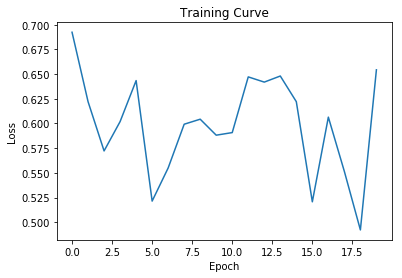

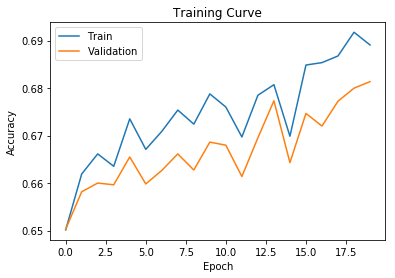

0.6789546079779918

In [54]:
model = TweetRNN(input_size=50, hidden_size=50, 2)
train_loader = TweetBatcher(train, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=64, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-4)
get_accuracy(model, test_loader)

The hidden size and the input embedding size don't have to be the same.

Epoch 1; Loss 0.665076; Train Acc 0.657650; Val Acc 0.650839
Epoch 2; Loss 0.585206; Train Acc 0.669552; Val Acc 0.661747
Epoch 3; Loss 0.577546; Train Acc 0.664938; Val Acc 0.653405
Epoch 4; Loss 0.613476; Train Acc 0.669997; Val Acc 0.661564
Epoch 5; Loss 0.604238; Train Acc 0.669966; Val Acc 0.658630
Epoch 6; Loss 0.519051; Train Acc 0.674484; Val Acc 0.666789
Epoch 7; Loss 0.626450; Train Acc 0.676394; Val Acc 0.668439
Epoch 8; Loss 0.637036; Train Acc 0.674675; Val Acc 0.664956
Epoch 9; Loss 0.608519; Train Acc 0.677412; Val Acc 0.668989
Epoch 10; Loss 0.618248; Train Acc 0.681963; Val Acc 0.671189
Epoch 11; Loss 0.577892; Train Acc 0.681485; Val Acc 0.668164
Epoch 12; Loss 0.616474; Train Acc 0.685304; Val Acc 0.671831
Epoch 13; Loss 0.518737; Train Acc 0.684731; Val Acc 0.668897
Epoch 14; Loss 0.624070; Train Acc 0.684763; Val Acc 0.675314
Epoch 15; Loss 0.557582; Train Acc 0.688296; Val Acc 0.673847
Epoch 16; Loss 0.430896; Train Acc 0.684063; Val Acc 0.667156
Epoch 17; Loss 0.

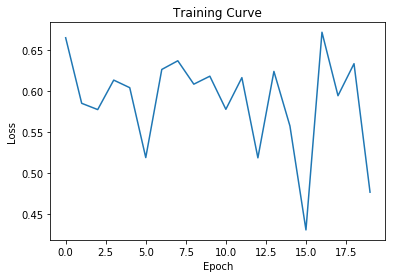

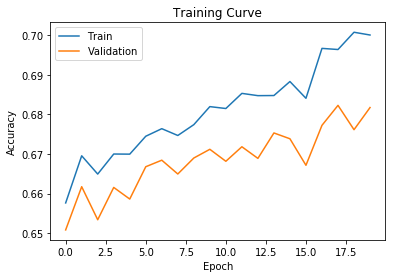

0.6860155891792755

In [56]:
model = TweetRNN(50, 100, 2)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-4)get_accuracy(model, test_loader)

In [66]:
tweet = "hello"

idxs = [glove.stoi[w]
        for w in split_tweet(tweet)
        if w in glove.stoi] 
print(idxs)
idxs = torch.tensor(idxs).long()

idxs.shape

[]


torch.Size([0])

## LSTM for Long-Term Dependencies

There are variations of recurrent neural networks that are more powerful.
One such variation is the 
Long Short-Term Memory (LSTM) module. An LSTM is like a more powerful version of an RNN that
is better at perpetuating long-term dependencies. Instead of having only one
hidden state, an LSTM keeps track of both a hidden state and a **cell state**.

In [69]:
lstm_layer = nn.LSTM(input_size=50,   # dimension of the input repr
                     hidden_size=50,   # dimension of the hidden units
                     batch_first=True) # input format is [batch_size, seq_len, repr_dim]

Remember the single tweet that we worked with earlier?

In [70]:
tweet_emb.shape

torch.Size([31, 50])

This is how we can feed this tweet into the LSTM, similar to what we tried with the RNN earlier.

In [71]:
tweet_input = tweet_emb.unsqueeze(0) # add the batch_size dimension
h0 = torch.zeros(1, 1, 50)     # initial hidden layer
c0 = torch.zeros(1, 1, 50)     # initial cell state

out, last_hidden = lstm_layer(tweet_input, (h0, c0))
out.shape

torch.Size([1, 31, 50])

In [73]:
hidden, cell = last_hidden

In [74]:
hidden

tensor([[[-0.0644,  0.0339, -0.2575, -0.2158,  0.1081,  0.1488, -0.0232,
          -0.0903,  0.0400, -0.0364,  0.1479, -0.3234, -0.3058, -0.1086,
           0.0851,  0.3204,  0.1840, -0.0843, -0.1059,  0.0670,  0.0651,
           0.2283, -0.0444,  0.1482,  0.0504,  0.0262,  0.0622, -0.2392,
          -0.0966, -0.0439,  0.1305,  0.2857,  0.0050, -0.0448,  0.1977,
           0.1048, -0.1074,  0.0841, -0.0611,  0.2816, -0.0524,  0.4009,
          -0.0921, -0.0438,  0.1370, -0.0123, -0.1178,  0.2372, -0.0065,
           0.0896]]], grad_fn=<StackBackward>)

So an LSTM version of our model would look like this:

Epoch 1; Loss 0.548256; Train Acc 0.705448; Val Acc 0.681914
Epoch 2; Loss 0.567127; Train Acc 0.704016; Val Acc 0.676689
Epoch 3; Loss 0.557029; Train Acc 0.705066; Val Acc 0.678522
Epoch 4; Loss 0.565069; Train Acc 0.705703; Val Acc 0.679897
Epoch 5; Loss 0.593701; Train Acc 0.706753; Val Acc 0.684114
Epoch 6; Loss 0.527148; Train Acc 0.707612; Val Acc 0.683197
Epoch 7; Loss 0.510399; Train Acc 0.707198; Val Acc 0.686131
Epoch 8; Loss 0.560238; Train Acc 0.706816; Val Acc 0.684389
Epoch 9; Loss 0.591500; Train Acc 0.707326; Val Acc 0.681914
Epoch 10; Loss 0.548669; Train Acc 0.708535; Val Acc 0.683289
Epoch 11; Loss 0.532838; Train Acc 0.708662; Val Acc 0.683197
Epoch 12; Loss 0.515204; Train Acc 0.709617; Val Acc 0.682281
Epoch 13; Loss 0.596891; Train Acc 0.707485; Val Acc 0.686406
Epoch 14; Loss 0.530933; Train Acc 0.707548; Val Acc 0.686772
Epoch 15; Loss 0.580535; Train Acc 0.710062; Val Acc 0.684664
Epoch 16; Loss 0.542818; Train Acc 0.711685; Val Acc 0.684206
Epoch 17; Loss 0.

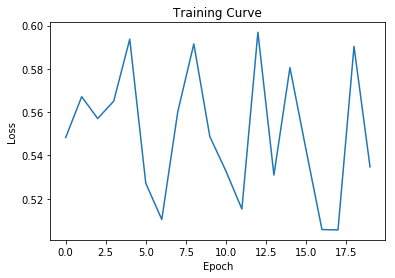

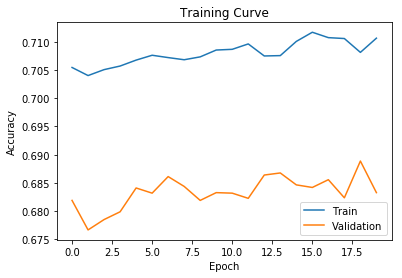

0.6949105914718019

In [77]:
class TweetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetLSTM, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

model_lstm = TweetLSTM(50, 50, 2)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-5)
get_accuracy(model, test_loader)

## GRU for Long-Term Dependencies

Another variation of an RNN is the Gated-Recurrent Unit (GRU).
The GRU is invented after LSTM, and is intended to be a simplification
of the LSTM that is still just as powerful. The nice thing about GRU units
is that they have only one hidden state.

In [75]:
gru_layer = nn.GRU(input_size=50,   # dimension of the input repr
                   hidden_size=50,   # dimension of the hidden units
                   batch_first=True) # input format is [batch_size, seq_len, repr_dim]

The GRU API is virtually identical to that of the vanilla RNN:

In [76]:
tweet_input = tweet_emb.unsqueeze(0) # add the batch_size dimension
h0 = torch.zeros(1, 1, 50)     # initial hidden layer
out, last_hidden = gru_layer(tweet_input, h0)
out.shape

torch.Size([1, 31, 50])

So a GRU version of our model would look similar to before:

Epoch 1; Loss 0.595435; Train Acc 0.709744; Val Acc 0.687689
Epoch 2; Loss 0.605396; Train Acc 0.711654; Val Acc 0.686314
Epoch 3; Loss 0.501910; Train Acc 0.711113; Val Acc 0.682647
Epoch 4; Loss 0.511382; Train Acc 0.712799; Val Acc 0.684664
Epoch 5; Loss 0.526580; Train Acc 0.712735; Val Acc 0.685306
Epoch 6; Loss 0.497839; Train Acc 0.712958; Val Acc 0.688056
Epoch 7; Loss 0.581980; Train Acc 0.711908; Val Acc 0.686681
Epoch 8; Loss 0.579690; Train Acc 0.712195; Val Acc 0.681547
Epoch 9; Loss 0.542231; Train Acc 0.713881; Val Acc 0.686131
Epoch 10; Loss 0.488401; Train Acc 0.713531; Val Acc 0.684022
Epoch 11; Loss 0.605408; Train Acc 0.714168; Val Acc 0.685856
Epoch 12; Loss 0.488853; Train Acc 0.715950; Val Acc 0.684847
Epoch 13; Loss 0.564983; Train Acc 0.714231; Val Acc 0.684206
Epoch 14; Loss 0.652606; Train Acc 0.715472; Val Acc 0.686314
Epoch 15; Loss 0.515072; Train Acc 0.714995; Val Acc 0.683289
Epoch 16; Loss 0.553718; Train Acc 0.716077; Val Acc 0.685031
Epoch 17; Loss 0.

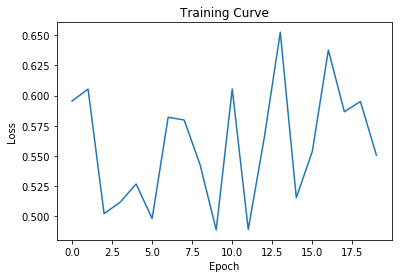

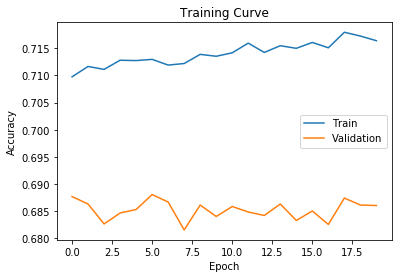

0.6987620357634112

In [78]:
class TweetGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetGRU, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the GRU 
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

model_lstm = TweetGRU(50, 50, 2)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-5)
get_accuracy(model, test_loader)